In [8]:
# imports 
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
import pickle

import lightning as L
seed = 42
L.seed_everything(seed, workers=True)

import xarray as xr
import xskillscore as xs
import warnings
import os


from src.models.unet_module import UnetLitModule
from src.models.gan_module import UnetGANLitModule
from src.models.ae_module import AutoencoderKL, EncoderLRES
from src.models.ldm_module import LatentDiffusion

from src.models.components.unet import DownscalingUnet
from src.models.components.ae import SimpleConvDecoder, SimpleConvEncoder
from src.models.components.ldm.denoiser import UNetModel, DDIMSampler
from src.models.components.ldm.conditioner import AFNOConditionerNetCascade
from src.data.downscaling_datamodule import DownscalingDataModule
from src.data.components.downscaling_dataset import DownscalingDataset

from utils.inference_utils import get_model_output
from utils.plotting_utils import get_target_grid, show_metrics, from_torchtensor_to_xarray

[rank: 0] Global seed set to 42


In [9]:
# Setting paths to data

# results_file_path = '../outputs/results_pde.pkl'
results_file_path = '../outputs/Our_results_trained_models_2mT.pkl'
pretrained_metrics_file_path = '../pretrained_models/outputs/metrics_trained_models.pkl'
output_path = '../outputs/'

In [10]:
#Loading in dataframes

results_df = pd.read_pickle(results_file_path)
pretrained_metrics_df = pd.read_pickle(pretrained_metrics_file_path)

In [11]:
#printing head and tails

print(results_df.columns)
print(results_df.shape)
print(results_df.head())
print(results_df.tail())

print_metrics = True
if print_metrics:
    print(f'\n\n =======================Pretrained Metrics below======================= \n\n')

    print(pretrained_metrics_df.columns)
    print(pretrained_metrics_df.shape)
    print(pretrained_metrics_df.head())
    print(pretrained_metrics_df.tail())
    print(pretrained_metrics_df['metric'].unique().tolist())

Index(['input_var', 'target_var', 'model', 'variable', 'spat_distr', 'min',
       'max', 'time_step'],
      dtype='object')
(210, 8)
  input_var target_var model variable  \
0       all        2mT  ERA5      2mT   
1       all        2mT  ERA5      2mT   
2       all        2mT  ERA5      2mT   
3       all        2mT  ERA5      2mT   
4       all        2mT  ERA5      2mT   

                                          spat_distr         min         max  \
0  [[tensor(282.5619), tensor(282.5619), tensor(2...  272.312256  290.437225   
1  [[tensor(273.5626), tensor(273.5626), tensor(2...  258.944519  289.312317   
2  [[tensor(287.2497), tensor(287.2497), tensor(2...  281.060699  300.498718   
3  [[tensor(289.4377), tensor(289.4377), tensor(2...  275.939758  301.378571   
4  [[tensor(277.4988), tensor(277.4988), tensor(2...  269.379364  290.562653   

            time_step  
0 2014-04-24 02:00:00  
1 2014-12-28 03:00:00  
2 2019-09-02 02:00:00  
3 2006-05-14 10:00:00  
4 2016-05-02 04:0

In [12]:
# split results_df into separate dataframes, one per model

model_types = results_df['model'].unique().tolist()

results = {}
for model_type in model_types:
    model_df = results_df[results_df['model'] == model_type]
    model_df = model_df.reset_index(drop=True)
    results[model_type] = model_df

print(results.keys())

dict_keys(['ERA5', 'COSMO-CLM', 'Quadratic Interp.', 'UNET', 'GAN', 'LDM_res', 'LDM_PDE_res'])


In [13]:
# Computing metrics for each model
metric_models = [model for model in model_types if model not in ['ERA5', 'COSMO-CLM']]
metrics_list = []

target_grid_high_res = get_target_grid('high')

for model_i in metric_models:
    for ts_idx, model_i_row in results[model_i].iterrows():
        # Extracting the corresponding target data
        cosmo_row = results['COSMO-CLM'].iloc[ts_idx]
        assert(cosmo_row['time_step'] == model_i_row['time_step'] and
               cosmo_row['input_var'] == model_i_row['input_var'] and
               cosmo_row['target_var'] == model_i_row['target_var'] and
               cosmo_row['variable'] == model_i_row['variable'])

        cosmo_spat_distr = cosmo_row['spat_distr']
        model_i_spat_distr = model_i_row['spat_distr']

        cosmo_xr = from_torchtensor_to_xarray(cosmo_spat_distr, target_grid_high_res, coords_name='y_x')
        model_i_xr = from_torchtensor_to_xarray(model_i_spat_distr, target_grid_high_res, coords_name='y_x')

        # Computing the 4 metrics listed in Appendix B
        model_i_rmse = xs.rmse(model_i_xr, cosmo_xr).item() # RMSE
        model_i_me = xs.me(model_i_xr, cosmo_xr).item() # BIAS (mean error)
        model_i_r2 = xs.r2(model_i_xr, cosmo_xr).item() # coefficient of determination
        model_i_pearson = xs.pearson_r(model_i_xr, cosmo_xr).item() # Pearson correlation

        # Appending the metrics to the list
        model_i_metrics = {
            'RMSE': model_i_rmse,
            'R2': model_i_r2,
            'BIAS': model_i_me,
            'PCC': model_i_pearson
        }

        for model_i_metric in model_i_metrics:
            metrics_list.append({
                'model': model_i,
                'target_var': model_i_row['target_var'],
                'var': model_i_row['variable'],
                'metric': model_i_metric,
                'value': model_i_metrics[model_i_metric],
            })

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df)
metrics_df.to_pickle(output_path + './Our_inference_metrics' + '.pkl')  

                 model target_var  var metric     value
0    Quadratic Interp.        2mT  2mT   RMSE  1.901043
1    Quadratic Interp.        2mT  2mT     R2  0.775449
2    Quadratic Interp.        2mT  2mT   BIAS -0.696168
3    Quadratic Interp.        2mT  2mT    PCC  0.897757
4    Quadratic Interp.        2mT  2mT   RMSE  1.952612
..                 ...        ...  ...    ...       ...
595        LDM_PDE_res        2mT  2mT    PCC  0.936240
596        LDM_PDE_res        2mT  2mT   RMSE  1.398368
597        LDM_PDE_res        2mT  2mT     R2  0.865531
598        LDM_PDE_res        2mT  2mT   BIAS -0.255771
599        LDM_PDE_res        2mT  2mT    PCC  0.933150

[600 rows x 5 columns]


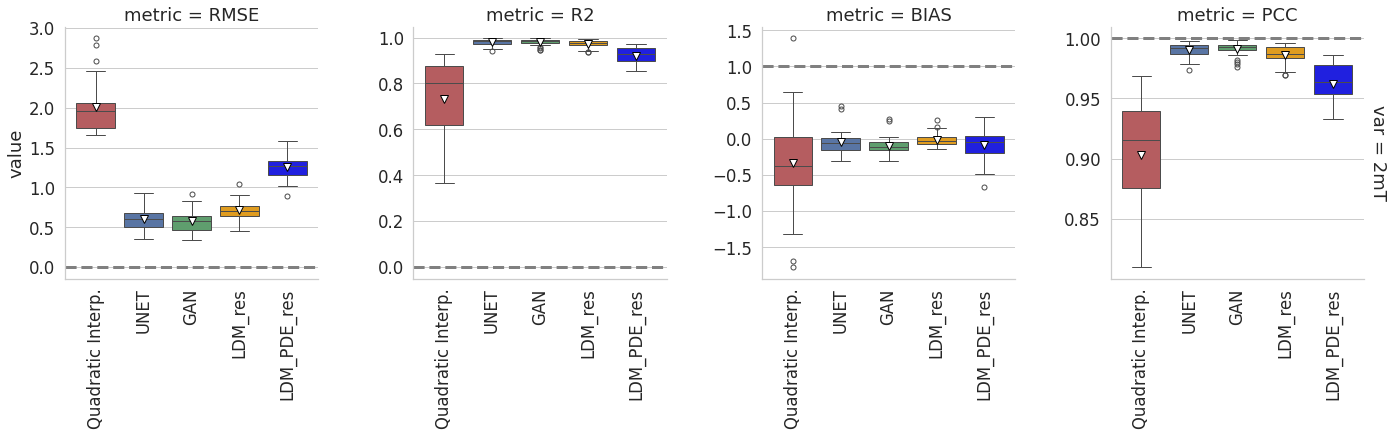

In [14]:
# Plotting metrics
def show_mT_metrics(metrics, output_dir, save_to_file):
    """
    Slightly modified version of show_metrics from utils.plotting_utils
    """

    # Set up plotting resources
    box_palette = {'Quadratic Interp.': 'r',
                'UNET':'b',
                'GAN': 'g',
                'VAE_res': 'pink',
                'LDM_res': 'orange',
                'LDM_PDE_res': 'blue'}
    y_ref = [0,0,1,1,0,0,1,1]
    # Plot boxplots
    sns.set_theme(font_scale=1.5, style="whitegrid")
    g = sns.catplot(data=metrics, kind='box', x="model", y="value", col="metric", row='var', hue='model', native_scale=True, sharey=False, margin_titles=True, palette=box_palette, showmeans=True,
                    meanprops={'marker':'v','markerfacecolor':'w','markeredgecolor':'black','markersize':'8'})
    for i,ax in enumerate(g.axes.flat):
        for label in ax.get_xticklabels():
            label.set_rotation(90)
        ax.axline((0, y_ref[i]), slope=0, linestyle='--', color='gray', linewidth=3)
        ax.set(xlabel=None)
    if g._legend is not None:
        g._legend.remove()

    if save_to_file:
        # Save to file
        g.savefig(output_dir + 'Fig_metrics.jpg')

show_mT_metrics(metrics_df, output_path, False)